#Part 4: Carlini and Wagner Attack

In [ ]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
carlini_wagner = CarliniWagnerL2(wrap, sess=sess)

#Attack parameters
cw_params = {'binary_search_steps':1,
             'learning_rate':1.25,
             'batch_size':16,
             'initial_const':10,
             'clip_min':0.,
             'clip_max':1.}


#Generate adversarial data
cw_adversarial_data_train = carlini_wagner.generate_np(data_train, **cw_params)
cw_adversarial_data_test = carlini_wagner.generate_np(data_test, **cw_params)


#Evaluate accuracy of perturbed data on target classifier
cw_perturbed_data_score = classifier.evaluate(cw_adversarial_data_test, labels_test)
print(f'Carlini and Wagner produced perturbed data has accuracy {cw_perturbed_data_score[1]*100}%')

10000/10000 [==============================] - 1s 53us/step
Carlini and Wagner produced perturbed data has accuracy 1.2000000104308128%


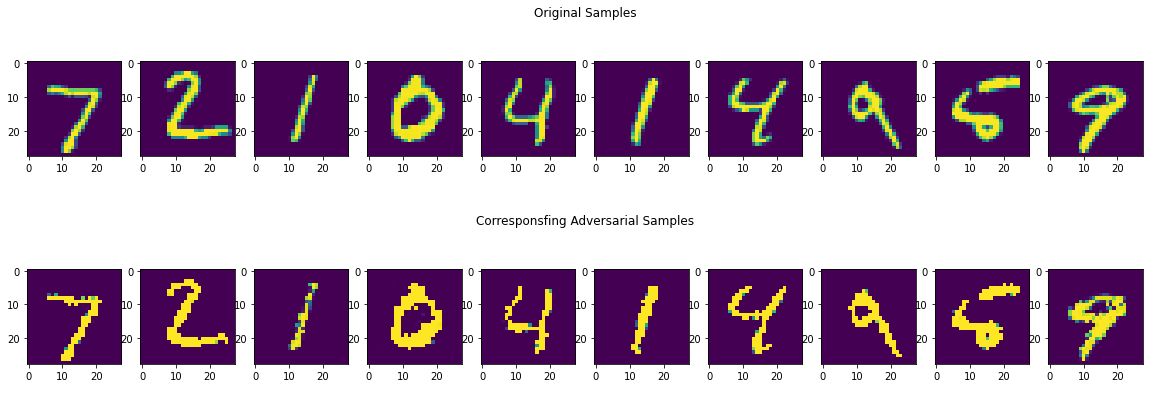

In [ ]:
#Show ten original samples and their corresponding adversarial samples
fig, axes = plt.subplots(2, 10, figsize=(20, 7))
grids = plt.GridSpec(2, 1)
titles = ['Original Samples', 'Corresponsfing Adversarial Samples']

for i in range(2):
  row = fig.add_subplot(grids[i])
  row.set_title(titles[i])
  row.set_axis_off()

for i in range(10):
  axes[0][i].imshow(data_test[i].reshape(28, 28))
  axes[1][i].imshow(cw_adversarial_data_test[i].reshape(28, 28))

In [ ]:
#Implementing the dimensionality reduction (PCA) defense 

#Calculate PCA projection
pca = PCA(100)
pca.fit(data_train)
pca_train = pca.transform(data_train)
pca_test = pca.transform(data_test)

#Transform perturbed CW data using the subspace from the original training data
cw_transformed_data_train = pca.transform(cw_adversarial_data_train)
cw_transformed_data_test = pca.transform(cw_adversarial_data_test)

# create model for PCA
def pca_model():
    model = Sequential()
    model.add(Dense(100, activation='relu', kernel_initializer='uniform', input_dim=100))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu', kernel_initializer='uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax', kernel_initializer='uniform'))

    return model

#Create model graph, compile it, and train it using pca_train lables_train 
pca = pca_model()
pca.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

pca_metadata = pca.fit(cw_transformed_data_train, labels_train,
                       validation_data=(cw_transformed_data_test, labels_test),
                       epochs=50,
                       batch_size=256,
                       shuffle=True)


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.5209 - accuracy: 0.8555 - val_loss: 0.8255 - val_accuracy: 0.9233
Epoch 2/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2161 - accuracy: 0.9340 - val_loss: 0.1938 - val_accuracy: 0.9418
Epoch 3/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.1594 - accuracy: 0.9513 - val_loss: 0.1596 - val_accuracy: 0.9488
Epoch 4/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.1299 - accuracy: 0.9600 - val_loss: 0.1471 - val_accuracy: 0.9489
Epoch 5/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.1111 - accuracy: 0.9650 - val_loss: 0.1415 - val_accuracy: 0.9527
Epoch 6/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.0939 - accuracy: 0.9705 - val_loss: 0.1384 - val_accuracy: 0.9567
Epoch 7/50
60000/60000 [==============================] - 1s 20us/s

In [ ]:
#Using the defense (and comparing to baseline accuracy)
pca_score = pca.evaluate(cw_transformed_data_test, labels_test)
print(f'PCA trained classifier accuracy on Carlini and Wagner Attack: {pca_score[1]*100}%')

10000/10000 [==============================] - 1s 58us/step
PCA trained classifier accuracy on Carlini and Wagner Attack: 95.67999839782715%
